<a href="https://colab.research.google.com/github/Hotchapu13/MRI_Uganda_lab_notebooks/blob/main/Convolutional_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Deep learning in Pytorch
An introductory lab to CNN implementation using Pytorch

**Author:** Leo Kinyera  
**Date:** 1st July, 2025  
**Company:** MRI-Uganda  
**Session:** Internship  


## Step 1: Import necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Step 2: Data transforms and Loading  

1. **DEFINE TRANSFORMATIONS**  
Transformations apply preprocessing to the data. We chain them together using transforms.Compose.  

2. transforms.ToTensor() does two things:
1. It converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
  into a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
  The channel dimension is moved to the front, which is the format PyTorch expects.



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download Dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Batched and dataloaders
BATCH_SIZE = 64

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 164kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.09MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.0MB/s]


## Visualize some input images

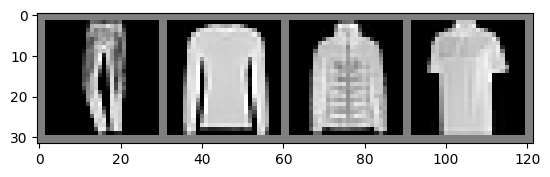

Trouser Pullover Coat  T-shirt/top


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{train_dataset.classes[labels[j]]:5s}' for j in range(4)))

## Step 3: Define the CNN Model Architecture

`nn.Conv2d` is a 2D convolutional layer.
- `in_channels=1`: The number of channels in the input image. For grayscale, this is 1.  

- `out_channels=16`: The number of filters (or kernels) the layer will learn. This is a design choice. It determines the number of feature maps in the output.  

- `kernel_size=3`: The size of the convolutional filter (3x3). A common choice.  

- `stride=1`: The step size the filter moves across the image. 1 means it moves one pixel at a time.  

- `padding=1`: Adds a 1-pixel border of zeros around the input image. This is "same" padding, meaning the output spatial dimensions (height, width) will be the same as the input when stride=1 and kernel_size=3. (Input: 28x28 -> Output: 28x28)

---  
- `nn.BatchNorm2d` normalizes the activations of the previous layer across the mini-batch.  
- It helps stabilize training and can speed up convergence.  


In [4]:
class FashionCNN(nn.Module):
    """
    A simple Convolutional Neural Network for Fashion-MNIST classification.
    """
    def __init__(self):
        """
        This is where we define all the layers of our network.
        """
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 7 * 7, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        """
        Defines the forward pass of the network.
        This method specifies how data flows through the layers defined in __init__.
        `x` is the input tensor (a batch of images).
        """
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc(out)
        return out

## Step 4: Instantiate the Model, Loss Function, and Optimizer  

### About the optimizer
---   
- The optimizer is responsible for updating the model's weights to minimize the loss.  

- `optim.Adam` is a very popular and effective optimization algorithm.   
- `model.parameters()`: This tells the optimizer which tensors (weights and biases) it should update.  
- `lr=0.001`: The learning rate. This is a crucial hyperparameter that controls how large the weight  
- updates are. 0.001 is a common and safe starting value for Adam.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create an instance of our model
model = FashionCNN()
model.to(device)

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


## Step 5: Training and Evaluation

In [7]:
num_epochs = 10

# Get the total number of batches in the training loader to calculate and print progress.
n_total_steps = len(train_loader)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    # Model evaluation
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            """
            - The class with the highest logit is what we choose as our prediction
            - torch.max returns (value, index)
            - We are interested in the index (the predicted class label)
            """
            _, predicted = torch.max(outputs.data, 1)

            # `n_samples` will be the total number of images in the test set.
            n_samples += labels.size(0)
            # `n_correct` will be the number of images the model classified correctly.
            n_correct += (predicted == labels).sum().item()

        # Calculate the accuracy
        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the 10000 test images: {acc:.2f} %')
        print('-' * 30)

print("Finished Training!")

Epoch [1/10], Step [200/938], Loss: 0.0692
Epoch [1/10], Step [400/938], Loss: 0.0660
Epoch [1/10], Step [600/938], Loss: 0.1044
Epoch [1/10], Step [800/938], Loss: 0.0723
Accuracy of the network on the 10000 test images: 91.72 %
------------------------------
Epoch [2/10], Step [200/938], Loss: 0.1024
Epoch [2/10], Step [400/938], Loss: 0.0838
Epoch [2/10], Step [600/938], Loss: 0.1123
Epoch [2/10], Step [800/938], Loss: 0.1705
Accuracy of the network on the 10000 test images: 91.46 %
------------------------------
Epoch [3/10], Step [200/938], Loss: 0.0818
Epoch [3/10], Step [400/938], Loss: 0.0523
Epoch [3/10], Step [600/938], Loss: 0.1173
Epoch [3/10], Step [800/938], Loss: 0.1345
Accuracy of the network on the 10000 test images: 91.01 %
------------------------------
Epoch [4/10], Step [200/938], Loss: 0.0231
Epoch [4/10], Step [400/938], Loss: 0.0428
Epoch [4/10], Step [600/938], Loss: 0.0670
Epoch [4/10], Step [800/938], Loss: 0.0254
Accuracy of the network on the 10000 test ima

## Visualize results

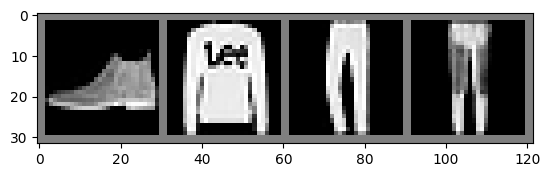

Actual:  Ankle boot Pullover   Trouser    Trouser   
Predicted:  Ankle boot Pullover   Trouser    Trouser   


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)

# Get predicted classes
_, predicted = torch.max(outputs.data, 1)

# Show images, we also need to move them to the CPU for plotting
imshow(torchvision.utils.make_grid(images[:4].cpu()))

# Print corresponding labels
print('Actual: ', ' '.join(f'{test_dataset.classes[labels[j]]:10s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{test_dataset.classes[predicted[j]]:10s}' for j in range(4)))

## Links to interesting learning pages
https://poloclub.github.io/cnn-explainer/  


https://www.pinecone.io/learn/series/image-search/cnn/  


https://adamharley.com/nn_vis/cnn/3d.html  